In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,auc, f1_score, confusion_matrix,precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.kaggle.com/becksddf/churn-in-telecoms-dataset

In [ ]:
df = pd.read_csv('/content/drive/My Drive/ML/Homework_3/telecom_churn.csv')

In [ ]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Функция препроцессинга датафрейма

In [ ]:
def transform_df(df):
  
  
  # True|False --> 1|0 && Yes|No --> 1|0
  df['Churn'] = df['Churn'].astype('int64') 
  df['International plan'] = df['International plan'].map({'Yes':1, 'No':0})
  df['Voice mail plan'] = df['Voice mail plan'].map({'Yes':1, 'No':0})
  
  # OneHotEncoding
  state_dummies = pd.get_dummies(df['State'], prefix = 'State')
  area_code_dummies = pd.get_dummies(df['Area code'], prefix='Area_code')
  df = pd.concat([df, state_dummies, area_code_dummies], axis=1)  
  df.drop(columns = ['State', 'Area code'], inplace=True) 
  
  
  # Нормировка
  columns_to_norm = [i for i in df.columns if 'Total' in i] + ['Number vmail messages'] + ['Account length'] + ['Customer service calls']
  for column in columns_to_norm:
    df[column] = df[column].apply(lambda x: x/df[column].mean())
    
  # Нормализация   
  yeo = PowerTransformer(method='yeo-johnson', standardize=False)
  for column in columns_to_norm:
    df[column] = yeo.fit_transform(df[column].values.reshape(df.shape[0],-1))
    
    
  columns_categorical = [i for i in df.columns if 'Area' in i or 'State' in i] + ['International plan'] + ['Voice mail plan']
  for column in columns_categorical:
    df[column] = yeo.fit_transform(df[column].values.reshape(df.shape[0],-1))
    
  
  return df

### Преобразуем датафрейм

In [ ]:
df = transform_df(df)

### Стандартизация

In [ ]:
cols_to_stand = [i for i in df.columns if i!='Churn']
scaler = MinMaxScaler()
scaler.fit(df[cols_to_stand])
df[cols_to_stand] = scaler.transform(df[cols_to_stand])

In [ ]:
def unpack_X_and_y(df, answers_col):
  return df.drop([answers_col],  axis=1), df[answers_col]

### Находим лучшие фичи и избавляемся от всех, кто не попал в топ

In [ ]:
def select_best_features(X, y):
  #apply SelectKBest class to extract top 10 best features
  bestfeatures = SelectKBest(score_func=chi2, k=10)
  fit = bestfeatures.fit(X,y)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(X.columns)
  #concat two dataframes for better visualization 
  featureScores = pd.concat([dfcolumns,dfscores],axis=1)
  featureScores.columns = ['Specs','Score']  #naming the dataframe columns
  return list(featureScores.nlargest(10,'Score')['Specs'])   #print 10 best features

In [ ]:
best_features = select_best_features(*unpack_X_and_y(df, 'Churn'))

In [ ]:
df = pd.concat([df[best_features], df['Churn']],axis=1)

In [ ]:
df.head()

,International plan,Voice mail plan,Number vmail messages,Customer service calls,State_NJ,Total day minutes,Total day charge,State_TX,State_MD,State_VA,Churn
0,0.0,1.0,0.959548,0.271336,0.0,0.750423,0.750420,0.0,0.0,0.0,0
1,0.0,1.0,0.962976,0.271336,0.0,0.452900,0.452832,0.0,0.0,0.0,0
2,0.0,0.0,0.000000,0.000000,1.0,0.687663,0.687647,0.0,0.0,0.0,0
3,1.0,0.0,0.000000,0.447103,0.0,0.849995,0.849969,0.0,0.0,0.0,0
4,1.0,0.0,0.000000,0.576547,0.0,0.467446,0.467427,0.0,0.0,0.0,0


### Делим датафрейм на X и y

In [ ]:
X, y = unpack_X_and_y(df, 'Churn')

### Функция для вывода оценки по разным метрикам

In [ ]:
def value_of_metrics(y_true, y_pred):
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred))
    print('Precision: ', precision_score(y_true, y_pred))  
    print('F1: ', f1_score(y_true, y_pred))
    print('Roc_AUC: ', roc_auc_score(y_true, y_pred))
    print('Confusion Matrix: ')
    print(pd.DataFrame(confusion_matrix(y_true, y_pred)))
    
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.title('My DataSet')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Используем метод GridSearch для определения лучших параметров RandomForest по метрике Recall.

In [ ]:
def get_grid_RFC(X, y, n_estimators, max_depth, scoring='recall', cv=5):
  grid_param = {
      'n_estimators': n_estimators,
      'max_depth': max_depth
  }
  
  classifier = RandomForestClassifier()
  
  grid = GridSearchCV(estimator=classifier,
                         param_grid=grid_param,
                         scoring=scoring,
                         cv=cv,
                         n_jobs=-1)
  
  grid.fit(X, y)
  
  return grid

### Разделим датасет на тренировочную и тестовую выборки 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [ ]:
grid_RFC_1 = get_grid_RFC(X_train, y_train, np.linspace(3, 50, 20, dtype=int), np.linspace(2, 15, 5, dtype=int))

Accuracy:  0.8932853717026379
Recall:  0.47619047619047616
Precision:  0.5952380952380952
F1:  0.5291005291005291
Roc_AUC:  0.7147756221830296
Confusion Matrix: 
     0   1
0  695  34
1   55  50


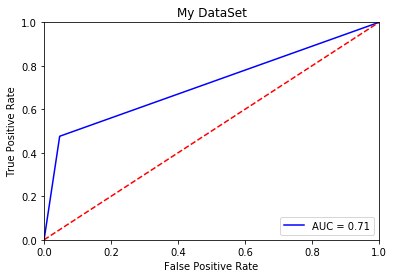

In [ ]:
value_of_metrics(y_test, grid_RFC_1.predict(X_test))

### Используем техники изменения объемов выборок

#### Добавляем копии объеков миноритарного класса

In [ ]:
not_churn = df[df.Churn==0]
churn = df[df.Churn==1]

churn_upsampled = resample(churn,
                          replace=True,
                          n_samples=len(not_churn), 
                          random_state=27)


upsampled = pd.concat([not_churn, churn_upsampled])

upsampled.Churn.value_counts()


1    2850
0    2850
Name: Churn, dtype: int64

Accuracy:  0.960431654676259
Recall:  0.9333333333333333
Precision:  0.7903225806451613
F1:  0.8558951965065502
Roc_AUC:  0.9488340192043896
Confusion Matrix: 
     0   1
0  703  26
1    7  98


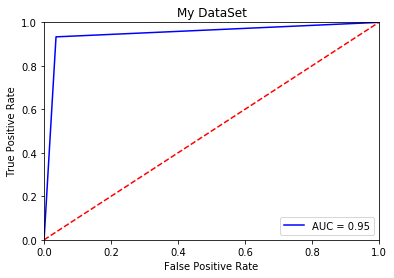

In [ ]:
y_train_new = upsampled.Churn
X_train_new = upsampled.drop('Churn', axis=1)

grid_RFC_2 = get_grid_RFC(X_train_new, y_train_new, np.linspace(3, 50, 20, dtype=int), np.linspace(2, 15, 5, dtype=int))

value_of_metrics(y_test, grid_RFC_2.predict(X_test))

#### Уменьшаем количество объектов мажоритарного класс

In [ ]:
not_churn_downsampled = resample(not_churn,
                                replace = False, 
                                n_samples = len(churn), 
                                random_state = 27)
downsampled = pd.concat([not_churn_downsampled, churn])
downsampled.Churn.value_counts()

1    483
0    483
Name: Churn, dtype: int64

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy:  0.8513189448441247
Recall:  0.8476190476190476
Precision:  0.4517766497461929
F1:  0.5894039735099338
Roc_AUC:  0.8497354497354498
Confusion Matrix: 
     0    1
0  621  108
1   16   89


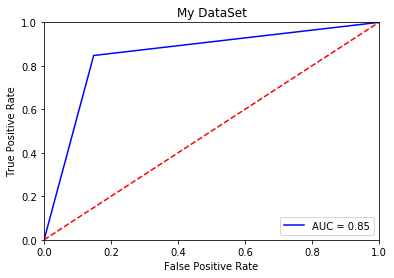

In [ ]:
y_train_new_new = downsampled.Churn
X_train_new_new = downsampled.drop('Churn', axis=1)

grid_RFC_3 = get_grid_RFC(X_train_new_new, y_train_new_new, np.linspace(3, 50, 20, dtype=int), np.linspace(2, 15, 5, dtype=int))

value_of_metrics(y_test, grid_RFC_3.predict(X_test))

#### Синтетическое увеличение миноритарного класса

Accuracy:  0.8345323741007195
Recall:  0.8285714285714286
Precision:  0.42028985507246375
F1:  0.5576923076923077
Roc_AUC:  0.8319811875367431
Confusion Matrix: 
     0    1
0  609  120
1   18   87


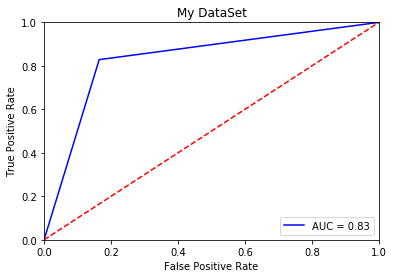

In [ ]:
sm = SMOTE(random_state=27, ratio=1.0)
X_train_new_new_new, y_train_new_new_new = sm.fit_sample(X_train, y_train)

grid_RFC_4 = get_grid_RFC(X_train_new_new_new, y_train_new_new_new, np.linspace(3, 50, 20, dtype=int), np.linspace(2, 15, 5, dtype=int))

value_of_metrics(y_test, grid_RFC_4.predict(X_test))